<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw3/part_c3_tensorflow_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Build tensorflow neural network using high level primitives and model subclassing

In [25]:
%matplotlib inline
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras import optimizers
import tensorflow as tf

#### 3d-2d non-linear data generation

In [26]:
n = 200
d = 3
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[3, 1, -1],[2, 0, -2],]).T
bias_true = np.array([0.5, 0.1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true

#Convert to tensor
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y_true, dtype=tf.float32)

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y.shape}')

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


#### Define subclassing models

Compose the model with linear dropout and relu layers

In [27]:
def compute_predictions(x, weights, bias):
    return tf.matmul(tf.pow(x,2), weights) + tf.matmul(x, weights) + bias

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MLPWithDropout(Layer):

  def __init__(self):
      super(MLPWithDropout, self).__init__()
      self.linear_1 = Linear(3)
      self.dropout = Dropout(0.2)
      self.linear_3 = Linear(2)

  def call(self, inputs, training=None):
      x = self.linear_1(inputs)
      x = tf.nn.relu(x)
      x = tf.nn.relu(x)
      x = self.dropout(x, training=training)
      return self.linear_3(x)

####Initialize learning rate and optimizer

In [28]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

####Do training loop with eporches

Computing gradients with GrandientTape

In [29]:
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = mlp(x)
    loss = tf.keras.losses.MSE(y, predictions)
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss, mlp.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

  return predictions, loss

In [30]:
# Shuffle the data.
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=100).batch(1)

mlp = MLPWithDropout()

for epoch in range(30):
  for step, (x_t, y_t) in enumerate(dataset):
    y_pred, loss = train_on_batch(x_t, y_t)
  if epoch % 10 ==0:
    print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 9.0869
Epoch 10: last batch loss = 27.2323
Epoch 20: last batch loss = 0.1773


In [31]:
y_pred = mlp(x)

In [32]:
y_pred.shape

TensorShape([200, 2])

####Plot the output and the real data using tsne

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_comparison(y_true, y_pred):
  #tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=120)
  tsne = TSNE(n_components=2, random_state=0)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(yt_2d[:, 0], yt_2d[:, 1], c='b', label='y_true')
  plt.scatter(yp_2d[:, 0], yp_2d[:, 1], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Comparison')
  plt.xlabel('t_SNE1')
  plt.xlabel('t_SNE2')
  plt.show()

def plot_distribution(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Distribution with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

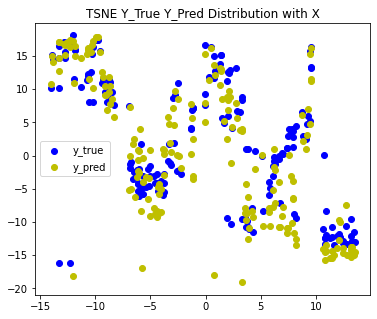

In [34]:
plot_distribution(x, y, y_pred)

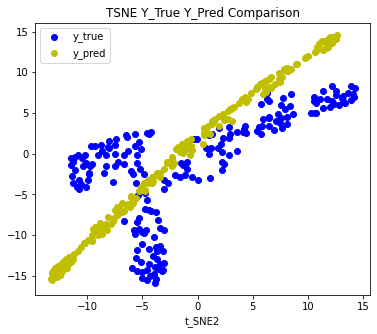

In [35]:
plot_comparison(y, y_pred)

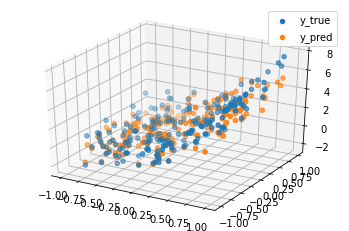

In [36]:
plot_3d(x, y[:, 0], y_pred=y_pred[:, 0])